In [1]:
import numpy as np
import sys
import copy
import math
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [226]:
np.set_printoptions( threshold = sys.maxsize )

class XY:
    def __init__( self, x_ = 0, y_ = 0 ):
        self.x = x_
        self.y = y_
    def __str__( self ):
        return self.ToString()
    def ToString( self ):
        return ( '( x: ' + str( self.x ) + ', y: ' + str( self.y ) + ' )' )

class Object2D:
    def __init__( self, sizeX_, sizeY_, pattern_ ):
        self.sizeX = sizeX_
        self.sizeY = sizeY_
        self.pattern = pattern_

class Mesh( Object2D ):
    def __init__( self, sizeX_, sizeY_, pattern_ ):
        super().__init__( sizeX_, sizeY_, pattern_ )
    def Copy( self ):
        return Mesh( self.sizeX, self.sizeY, copy.deepcopy( self.pattern ) )
    def Scale( self, xScale, yScale ):
        return self
    def AddMass( self, mass ):
        for x in range( len( self.pattern ) ):
            for y in range( len( x ) ):
                self.pattern[ x ][ y ] *= mass
        return self
    def ToMass( self, x, y ):
        return Mass( x, y, self )

class Planet( Mesh ):
    def __init__( self, radius_, distributedMass_, default_ = 0.0, ringDistance_ = 0.0, ringDepth_ = 0.0, increment = .01 ):
        self.radius = radius_
        self.ringDistance = ringDistance_
        self.default = default_
        self.ringDepth = ringDepth_
        self.ModifyMass( distributedMass_ )
        self.FillPlanet( self.radius, True, increment )
    def ModifyMass( self, distributedMass_ ):
        self.distributedMass = distributedMass_
        self.mass = ( 2.0 * np.pi * ( self.radius * self.radius ) ) * self.distributedMass
        return self
    def ChangeRadius( self, radius_, fillRing, increment = .01, ):
        self.FillPlanet( radius_, fillRing, increment )
        return self
    def FillPlanet( self, radius_, doFillRing = True, increment = .01, distributedMass_ = None ):
        trueRadius = int( self.radius + self.ringDistance + self.ringDepth ) * 2
        self.radius = radius_
        self.sizeX = trueRadius
        self.sizeY = trueRadius
        planet = []
        if distributedMass_ != None:
            self.ModifyMass( distributedMass_ )
        for i in range( self.sizeX ):
            planet.append( [ self.default ] * self.sizeY )
        for i in range( int( radius_ ) ):
            currentRadius = radius_ - i
            theta = 0.0
            while theta <= ( 2.0 * np.pi ):
                planet[ 
                    ( int( currentRadius ) - int( np.sin( theta ) * currentRadius ) ) + 
                    int( ( self.sizeX / 2.0 ) - ( currentRadius ) ) ][ int( currentRadius ) - 
                    int( np.cos( theta ) * currentRadius ) + 
                    int( ( self.sizeY / 2.0 ) - ( currentRadius ) ) ] = self.distributedMass
                theta += increment
        self.pattern = planet
        if doFillRing == True:
            self.FillRing( self.ringDistance, self.ringDepth, increment )
        return self
    
    def FillRing( self, ringDistance_ = None, ringDepth_ = None, increment = .01, fillPlanet = False ):
        if ringDistance_ == None:
            ringDistance_ = self.ringDistance
        else:
            self.ringDistance = ringDistance_
        if ringDepth_ == None:
            ringDepth_ = self.ringDepth
        else:
            self.ringDepth = ringDepth_
        trueRadius = int( self.radius + ringDistance_ + ringDepth_ ) * 2
        for i in range( int( ringDepth_ ) ):
            theta = 0.0
            while theta <= ( 2.0 * np.pi ):
                self.pattern[ 
                    ( int( i ) - int( np.sin( theta ) * ( ringDistance_ + self.radius + i ) ) ) + 
                    int( ( self.sizeX / 2.0 ) - ( i ) ) ][ int( i ) - 
                    int( np.cos( theta ) * ( ringDistance_ + self.radius + i ) ) + 
                    int( ( self.sizeY / 2.0 ) - ( i ) ) ] = self.distributedMass
                theta += increment
        return self
        
class Mass( Object2D ):
    def __init__( self, x_, y_, mesh, noDeepCopy = False ):
        if noDeepCopy == False:
            super().__init__( mesh.sizeX, mesh.sizeY, copy.deepcopy( mesh.pattern ) )
        else:
            super().__init__( mesh.sizeX, mesh.sizeY, mesh.pattern )
        self.x = x_
        self.y = y_
    def ToMesh( self ):
        return Mesh( self.sizeX, self.sizeY, copy.deepcopy( self.pattern ) )
    def Copy( self ):
        return Mass( self.x, self.y, self.ToMesh(), True )
    

class GravitySimulationFeild:
    def __init__( self, size, boundry_, default_ = 0, phi_ = [], masses_ = [], vectorFeild_ = [] ):
        self.phi = phi_
        self.vectorFeild = vectorFeild_
        self.masses = masses_
        self.boundry = boundry_
        self.default = default_
        if len( self.phi ) == 0:
            self.CreatePhi( size ).CreateBoundry( self.boundry ).SetDefault( self.default )
        if len( self.vectorFeild ) == 0:
            self.vectorFeild = self.CreateZero2DVectors( size )
        self.size = size
    def MakeObject( self, mesh, x, y ):
        self.masses.append( mesh.ToMass( x, y ) )
        return self
    def AddMass( self, mass ):
        self.masses.append( mass )
        return self
    def CreateZeros( self, size ):
        return np.zeros( [ size + 1, size + 1 ] )
    def CreateZero2DVectors( self, size ):
        building = [ [ XY() ] * ( size + 1 ) ] * ( size + 1 )
        for i in range( len( building ) ):
            for j in range( len( building[ i ] ) ):
                building[ i ][ j ] = XY()
        return building
    def CreatePhi( self, size ):
        self.phi = self.CreateZeros( size )
        #Fluid A.P.I
        return self
    def CreateBoundry( self, boundry ):
        size = len( self.phi ) - 1
        for i in range( size ):
            self.phi[ i ][ 0 ] = boundry
            self.phi[ 0 ][ i ] = boundry
            self.phi[ i ][ size ] = boundry
            self.phi[ size ][ i ] = boundry
        return self
    def SetDefault( self, default ):
        for i in range( 1, len( self.phi ) - 1 ):
            for j in range( 1, len( self.phi[ i ] ) - 1 ):
                self.phi[ i ][ j ] = default
        return self
    def AddMassesToFeild( self ):
        massfulPhi = copy.deepcopy( self.phi )
        for i in self.masses:
            for x in range( i.sizeX ):
                for y in range( i.sizeY ):
                    massfulPhi[ i.x + x ][ i.y + y ] = i.pattern[ x ][ y ]
        return GravitySimulationFeild( self.size, self.boundry, self.default, massfulPhi, copy.deepcopy( self.masses ), self.vectorFeild )
    def Calculate( self, maximumExecutions ):
        phiBase = copy.deepcopy( self.phi )
        phiCalculate = self.CreateZeros( self.size )
        for execution in range( maximumExecutions ):
            for x in range( 1, self.size ):
                for y in range( 1, self.size ):
                    phiCalculate[ x ][ y ] = .25 * ( phiBase[ x + 1 ][ y ] + phiBase[ x - 1 ][ y ] + phiBase[ x ][ y + 1 ] + phiBase[ x ][ y - 1 ] )
            for i in range( 1, self.size ):
                for j in range( 1, self.size ):
                    phiBase[ i ][ j ] = phiCalculate[ i ][ j ]
        return GravitySimulationFeild( self.size, self.boundry, self.default, phiBase, copy.deepcopy( self.masses ), self.vectorFeild )
    def CalculateVectorFeild( self, maximumExecutions, noDeepCopy = False, xStart = 1, yStart = 1, xEnd_ = None, yEnd_ = None ):
        if xEnd_ == None:
            xEnd_ = self.size
            yEnd_ = self.size
        for x in range( xStart, xEnd_ - 1 ):
            for y in range( yStart, yEnd_ - 1 ):
                self.vectorFeild[ x ][ y ].x = ( -( self.phi[ x + 1 ][ y ] - self.phi[ x - 1 ][ y ] ) / 2.0 )
                self.vectorFeild[ x ][ y ].y = ( -( self.phi[ x ][ y + 1 ] - self.phi[ x ][ y - 1 ] ) / 2.0 )
        return self
    def DisplayVectorFeild( self, blackAndWhite = False, normalize = True ):
        xPositions = self.CreateZeros( self.size )
        yPositions = self.CreateZeros( self.size )
        xDirections = self.CreateZeros( self.size )
        yDirections = self.CreateZeros( self.size )
        colors = self.CreateZeros( self.size )
        count = 0
        for i in range( len( xPositions ) ):
            for j in range( len( xPositions[ i ] ) ):
                if count == 40:
                    count = 0
                    xPositions[ i ][ j ] = i
                    yPositions[ i ][ j ] = j
                    currentVector = self.vectorFeild[ i ][ j ]
                    magnitude = np.sqrt( ( ( currentVector.x * currentVector.x ) + 
                                          ( currentVector.y * currentVector.y ) ) )
                    xDirections[ i ][ j ] = self.vectorFeild[ i ][ j ].x
                    yDirections[ i ][ j ] = self.vectorFeild[ i ][ j ].y
                    if normalize == True:
                        if magnitude != 0.0:
                            xDirections[ i ][ j ] /= magnitude
                            yDirections[ i ][ j ] /= magnitude
                    colors[ i ][ j ] = magnitude * 256
                else:
                    count += 1                    
        if blackAndWhite == False:
            plt.quiver( xPositions, yPositions, xDirections, yDirections, colors )
        else:
            plt.quiver( xPositions, yPositions, xDirections, yDirections )
        return self

In [227]:
g = GravitySimulationFeild( 200, -4.0, 3.0 )

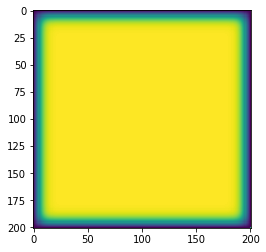

In [228]:
plt.imshow( g.Calculate( 100 ).phi )

In [229]:
p = Planet( 10.0, 10000.0, 0.0 )
q = p.pattern
p0 = Planet( 20.0, 10000.0, 0.0 )#, 0.0, 1, 1 )

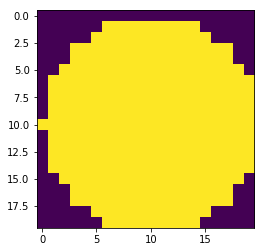

In [230]:
plt.imshow( q )

In [231]:
g.AddMass( p.ToMass( 10, 5 ) ).AddMass( p0.ToMass( 100, 100 ) )

In [232]:
g0 = g.AddMassesToFeild().Calculate( 200 )

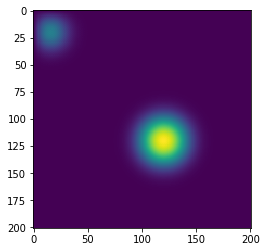

In [233]:
plt.imshow( g0.phi )

In [234]:
g1 = g0.CalculateVectorFeild( 100 )

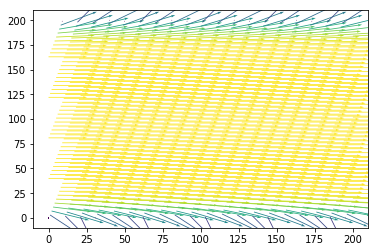

In [235]:
g1.DisplayVectorFeild()

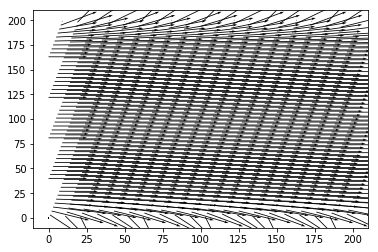

In [236]:
g1.DisplayVectorFeild( True )

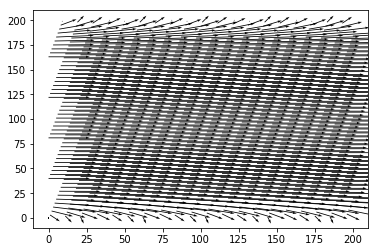

In [237]:
g1.DisplayVectorFeild( True, False )

In [238]:
for i in g1.vectorFeild:
    for j in i:
        print( j.ToString() )

( x: 0, y: 0 )
( x: 0.043364760036166405, y: -0.08759252173245846 )
( x: 0.0863001660125684, y: -0.0863001660125684 )
( x: 0.12839353781351126, y: -0.08419103469043243 )
( x: 0.16924886926736726, y: -0.08132225809294025 )
( x: 0.20851728072881692, y: -0.07777859746541393 )
( x: 0.24587945862417615, y: -0.07365464413906886 )
( x: 0.28108571543890903, y: -0.06906262143759312 )
( x: 0.31392232035264933, y: -0.06411731201336868 )
( x: 0.3442566160953868, y: -0.058939244290821424 )
( x: 0.37199082934588934, y: -0.053644241641373824 )
( x: 0.3971081173604256, y: -0.04834272011567342 )
( x: 0.419618894354586, y: -0.04313485132863093 )
( x: 0.4396046293215736, y: -0.03810707978746941 )
( x: 0.4571621908813568, y: -0.033332833364890124 )
( x: 0.47244335288404815, y: -0.028867417698360764 )
( x: 0.48560213127525387, y: -0.02475328145394773 )
( x: 0.4968289927144305, y: -0.021014257098027178 )
( x: 0.5063048757640103, y: -0.017663809517929563 )
( x: 0.5142298783759274, y: -0.014699300026675521 )


( x: 0.5458378315826735, y: -6.134315277961377e-11 )
( x: 0.5458378316101808, y: -4.361488947779435e-11 )
( x: 0.5458378316384849, y: -4.2223113894124253e-11 )
( x: 0.5458378316707819, y: -5.211653331116395e-11 )
( x: 0.5458378317209593, y: -7.468625717876876e-11 )
( x: 0.5458378317910544, y: -1.1140777189666551e-10 )
( x: 0.5458378319028028, y: -1.6742762731780658e-10 )
( x: 0.5458378320657185, y: -2.5317303808947145e-10 )
( x: 0.545837832312285, y: -3.7247560591424644e-10 )
( x: 0.5458378326794651, y: -5.573947969850224e-10 )
( x: 0.5458378332025229, y: -7.974823024170519e-10 )
( x: 0.5458378339967251, y: -1.177384412187621e-09 )
( x: 0.5458378350605579, y: -1.638550184424048e-09 )
( x: 0.5458378367079058, y: -2.384431097013362e-09 )
( x: 0.5458378387824268, y: -3.230806511211881e-09 )
( x: 0.5458378420596379, y: -4.630633210211954e-09 )
( x: 0.5458378459393618, y: -6.114706296855843e-09 )
( x: 0.5458378521935852, y: -8.625431480169254e-09 )
( x: 0.54583785915385, y: -1.1110676156889

( x: 0.5458377988735086, y: -3.965427874952354e-08 )
( x: 0.5458378131636978, y: -2.279425581619421e-08 )
( x: 0.5458378213135997, y: -1.2973218943557185e-08 )
( x: 0.5458378259250654, y: -7.2991737098959675e-09 )
( x: 0.5458378284989991, y: -4.0662875289143585e-09 )
( x: 0.5458378299246545, y: -2.2393262799624836e-09 )
( x: 0.545837830703573, y: -1.2213932087945523e-09 )
( x: 0.5458378311264847, y: -6.591631684926824e-10 )
( x: 0.5458378313533447, y: -3.5332137215959847e-10 )
( x: 0.5458378314758416, y: -1.892763723532198e-10 )
( x: 0.5458378315423915, y: -1.0344658463168344e-10 )
( x: 0.5458378315826735, y: -6.134315277961377e-11 )
( x: 0.5458378316101808, y: -4.361488947779435e-11 )
( x: 0.5458378316384849, y: -4.2223113894124253e-11 )
( x: 0.5458378316707819, y: -5.211653331116395e-11 )
( x: 0.5458378317209593, y: -7.468625717876876e-11 )
( x: 0.5458378317910544, y: -1.1140777189666551e-10 )
( x: 0.5458378319028028, y: -1.6742762731780658e-10 )
( x: 0.5458378320657185, y: -2.531730

( x: 0.5458320884776744, y: -5.605799774599518e-06 )
( x: 0.5458342463192338, y: -3.580894385679656e-06 )
( x: 0.5458356147065646, y: -2.264813677932409e-06 )
( x: 0.5458364753808334, y: -1.4168239654832604e-06 )
( x: 0.5458370098317904, y: -8.775787712078653e-07 )
( x: 0.5458373390191216, y: -5.375943745722367e-07 )
( x: 0.5458375391650192, y: -3.2606926980705e-07 )
( x: 0.5458376598746466, y: -1.955766637529166e-07 )
( x: 0.5458377317256176, y: -1.1614766637357832e-07 )
( x: 0.5458377741523894, y: -6.820358633419232e-08 )
( x: 0.5458377988735086, y: -3.965427874952354e-08 )
( x: 0.5458378131636978, y: -2.279425581619421e-08 )
( x: 0.5458378213135997, y: -1.2973218943557185e-08 )
( x: 0.5458378259250654, y: -7.2991737098959675e-09 )
( x: 0.5458378284989991, y: -4.0662875289143585e-09 )
( x: 0.5458378299246545, y: -2.2393262799624836e-09 )
( x: 0.545837830703573, y: -1.2213932087945523e-09 )
( x: 0.5458378311264847, y: -6.591631684926824e-10 )
( x: 0.5458378313533447, y: -3.53321372159

( x: 0.5453077422481458, y: -0.0003914461077738629 )
( x: 0.5454688741018725, y: -0.00028011169321562335 )
( x: 0.5455835701143879, y: -0.00019835878292684406 )
( x: 0.5456642461231913, y: -0.00013907838805748973 )
( x: 0.5457205117496697, y: -9.649339657102907e-05 )
( x: 0.5457592830216969, y: -6.628624013416129e-05 )
( x: 0.5457857746237733, y: -4.505527880205307e-05 )
( x: 0.5458036564551754, y: -3.0321846210323855e-05 )
( x: 0.5458156259303939, y: -2.018955790283883e-05 )
( x: 0.545823539633018, y: -1.3310226489426924e-05 )
( x: 0.5458287284840033, y: -8.680962578777596e-06 )
( x: 0.5458320884776744, y: -5.605799774599518e-06 )
( x: 0.5458342463192338, y: -3.580894385679656e-06 )
( x: 0.5458356147065646, y: -2.264813677932409e-06 )
( x: 0.5458364753808334, y: -1.4168239654832604e-06 )
( x: 0.5458370098317904, y: -8.775787712078653e-07 )
( x: 0.5458373390191216, y: -5.375943745722367e-07 )
( x: 0.5458375391650192, y: -3.2606926980705e-07 )
( x: 0.5458376598746466, y: -1.955766637529

( x: 0.5340201352245721, y: -0.006379174011918121 )
( x: 0.5368027067792349, y: -0.005049831402874849 )
( x: 0.5389941846299027, y: -0.003957101763457205 )
( x: 0.5407008222481209, y: -0.003070197139211084 )
( x: 0.5420181579706691, y: -0.0023578793856482427 )
( x: 0.5430234931273503, y: -0.0017929389243172 )
( x: 0.5437840080510721, y: -0.0013494357214396402 )
( x: 0.5443527409505509, y: -0.0010056048749431667 )
( x: 0.5447743620785406, y: -0.0007416858113236113 )
( x: 0.5450833085947404, y: -0.0005416277362093602 )
( x: 0.5453077422481458, y: -0.0003914461077738629 )
( x: 0.5454688741018725, y: -0.00028011169321562335 )
( x: 0.5455835701143879, y: -0.00019835878292684406 )
( x: 0.5456642461231913, y: -0.00013907838805748973 )
( x: 0.5457205117496697, y: -9.649339657102907e-05 )
( x: 0.5457592830216969, y: -6.628624013416129e-05 )
( x: 0.5457857746237733, y: -4.505527880205307e-05 )
( x: 0.5458036564551754, y: -3.0321846210323855e-05 )
( x: 0.5458156259303939, y: -2.018955790283883e-0

( x: 0.419618894354586, y: -0.04313485132863093 )
( x: 0.4396046293215736, y: -0.03810707978746941 )
( x: 0.4571621908813568, y: -0.033332833364890124 )
( x: 0.47244335288404815, y: -0.028867417698360764 )
( x: 0.48560213127525387, y: -0.02475328145394773 )
( x: 0.4968289927144305, y: -0.021014257098027178 )
( x: 0.5063048757640103, y: -0.017663809517929563 )
( x: 0.5142298783759274, y: -0.014699300026675521 )
( x: 0.5207860169003309, y: -0.012111499859468244 )
( x: 0.5261606563635544, y: -0.009879271613720597 )
( x: 0.5305184721445464, y: -0.007978859704717234 )
( x: 0.5340201352245721, y: -0.006379174011918121 )
( x: 0.5368027067792349, y: -0.005049831402874849 )
( x: 0.5389941846299027, y: -0.003957101763457205 )
( x: 0.5407008222481209, y: -0.003070197139211084 )
( x: 0.5420181579706691, y: -0.0023578793856482427 )
( x: 0.5430234931273503, y: -0.0017929389243172 )
( x: 0.5437840080510721, y: -0.0013494357214396402 )
( x: 0.5443527409505509, y: -0.0010056048749431667 )
( x: 0.544774

( x: 0.5458395240481098, y: -3.5835378509041504e-07 )
( x: 0.5458397261630139, y: -3.8080747488677957e-07 )
( x: 0.5458401402650712, y: -4.3793170378947366e-07 )
( x: 0.5458403742224698, y: -4.5579767693482154e-07 )
( x: 0.5458408748514465, y: -5.108575347190225e-07 )
( x: 0.5458411305294943, y: -5.201920629804846e-07 )
( x: 0.545841709876044, y: -5.67249792027269e-07 )
( x: 0.5458419709662308, y: -5.640521101302198e-07 )
( x: 0.5458426118422248, y: -5.969502205882549e-07 )
( x: 0.5458428562714635, y: -5.778246763288308e-07 )
( x: 0.5458435325512789, y: -5.911892109189409e-07 )
( x: 0.5458437339735596, y: -5.540601344389273e-07 )
( x: 0.5458444125994726, y: -5.443084543088617e-07 )
( x: 0.5458445429290946, y: -4.890471412277719e-07 )
( x: 0.5458451873047074, y: -4.5516781388421634e-07 )
( x: 0.5458452200391211, y: -3.8398259127880863e-07 )
( x: 0.5458457943015493, y: -3.278918003779552e-07 )
( x: 0.5458457081718435, y: -2.4535816933735077e-07 )
( x: 0.5458461816042153, y: -1.7173204702

( x: 0.5458457081898072, y: 2.453501317667417e-07 )
( x: 0.5458457943464625, y: 3.2787618708951527e-07 )
( x: 0.5458452200700599, y: 3.83973871143084e-07 )
( x: 0.5458451873746133, y: 4.5515084323710653e-07 )
( x: 0.5458445429741219, y: 4.890377933719492e-07 )
( x: 0.5458444126963458, y: 5.442905277597276e-07 )
( x: 0.5458437340334221, y: 5.54050858303512e-07 )
( x: 0.5458435326759279, y: 5.911720042384161e-07 )
( x: 0.5458428563453779, y: 5.778178691073776e-07 )
( x: 0.5458426119920659, y: 5.96938684260806e-07 )
( x: 0.5458419710487441, y: 5.640558105035609e-07 )
( x: 0.545841710039126, y: 5.67259677008991e-07 )
( x: 0.5458411305999158, y: 5.202344561805461e-07 )
( x: 0.5458408749864456, y: 5.109425593730066e-07 )
( x: 0.5458403742075404, y: 4.5597777864614386e-07 )
( x: 0.5458401402317086, y: 4.3827637696836064e-07 )
( x: 0.5458397258082401, y: 3.8146338754430076e-07 )
( x: 0.5458395233722593, y: 3.595742805728719e-07 )
( x: 0.5458391943071292, y: 3.0632825431808897e-07 )
( x: 0.5458

( x: 0.5340201352314189, y: 0.006379174016313938 )
( x: 0.5305184721484295, y: 0.007978859707286512 )
( x: 0.5261606563659331, y: 0.009879271615307106 )
( x: 0.5207860169016385, y: 0.012111499860366193 )
( x: 0.5142298783767179, y: 0.014699300027223083 )
( x: 0.5063048757644317, y: 0.017663809518229545 )
( x: 0.49682899271468184, y: 0.021014257098207256 )
( x: 0.485602131275384, y: 0.024753281454043208 )
( x: 0.4724433528841243, y: 0.028867417698418052 )
( x: 0.457162190881395, y: 0.033332833364919434 )
( x: 0.4396046293215954, y: 0.03810707978748629 )
( x: 0.41961889435459643, y: 0.04313485132863892 )
( x: 0.39710811736043206, y: 0.04834272011567875 )
( x: 0.3719908293458922, y: 0.05364424164137649 )
( x: 0.3442566160953884, y: 0.05893924429082209 )
( x: 0.31392232035265, y: 0.06411731201336934 )
( x: 0.28108571543890903, y: 0.06906262143759356 )
( x: 0.24587945862417682, y: 0.07365464413906908 )
( x: 0.2085172807288167, y: 0.07777859746541416 )
( x: 0.16924886926736749, y: 0.08132225

( x: 0.5458378314758416, y: -1.892763723532198e-10 )
( x: 0.5458378315423915, y: -1.0344658463168344e-10 )
( x: 0.5458378315826735, y: -6.134315277961377e-11 )
( x: 0.5458378316101808, y: -4.361488947779435e-11 )
( x: 0.5458378316384849, y: -4.2223113894124253e-11 )
( x: 0.5458378316707819, y: -5.211653331116395e-11 )
( x: 0.5458378317209593, y: -7.468625717876876e-11 )
( x: 0.5458378317910544, y: -1.1140777189666551e-10 )
( x: 0.5458378319028028, y: -1.6742762731780658e-10 )
( x: 0.5458378320657185, y: -2.5317303808947145e-10 )
( x: 0.545837832312285, y: -3.7247560591424644e-10 )
( x: 0.5458378326794651, y: -5.573947969850224e-10 )
( x: 0.5458378332025229, y: -7.974823024170519e-10 )
( x: 0.5458378339967251, y: -1.177384412187621e-09 )
( x: 0.5458378350605579, y: -1.638550184424048e-09 )
( x: 0.5458378367079058, y: -2.384431097013362e-09 )
( x: 0.5458378387824268, y: -3.230806511211881e-09 )
( x: 0.5458378420596379, y: -4.630633210211954e-09 )
( x: 0.5458378459393618, y: -6.1147062968

( x: 0.5458377741523894, y: -6.820358633419232e-08 )
( x: 0.5458377988735086, y: -3.965427874952354e-08 )
( x: 0.5458378131636978, y: -2.279425581619421e-08 )
( x: 0.5458378213135997, y: -1.2973218943557185e-08 )
( x: 0.5458378259250654, y: -7.2991737098959675e-09 )
( x: 0.5458378284989991, y: -4.0662875289143585e-09 )
( x: 0.5458378299246545, y: -2.2393262799624836e-09 )
( x: 0.545837830703573, y: -1.2213932087945523e-09 )
( x: 0.5458378311264847, y: -6.591631684926824e-10 )
( x: 0.5458378313533447, y: -3.5332137215959847e-10 )
( x: 0.5458378314758416, y: -1.892763723532198e-10 )
( x: 0.5458378315423915, y: -1.0344658463168344e-10 )
( x: 0.5458378315826735, y: -6.134315277961377e-11 )
( x: 0.5458378316101808, y: -4.361488947779435e-11 )
( x: 0.5458378316384849, y: -4.2223113894124253e-11 )
( x: 0.5458378316707819, y: -5.211653331116395e-11 )
( x: 0.5458378317209593, y: -7.468625717876876e-11 )
( x: 0.5458378317910544, y: -1.1140777189666551e-10 )
( x: 0.5458378319028028, y: -1.6742762

( x: 0.5458395233722593, y: 3.595742805728719e-07 )
( x: 0.5458391943071292, y: 3.0632825431808897e-07 )
( x: 0.5458390271259248, y: 2.8450027578230674e-07 )
( x: 0.5458387750886482, y: 2.3976787333346294e-07 )
( x: 0.5458386408023357, y: 2.2310836644834353e-07 )
( x: 0.5458384508250402, y: 1.9311928545207024e-07 )
( x: 0.545838339573139, y: 1.905510484956352e-07 )
( x: 0.5458381876957019, y: 1.8789897748838769e-07 )
( x: 0.5458380758639052, y: 2.2004819810739207e-07 )
( x: 0.5458379186783575, y: 2.762982815873727e-07 )
( x: 0.545837750361279, y: 3.94692257765783e-07 )
( x: 0.5458374952524634, y: 5.898540114124273e-07 )
( x: 0.5458371347514321, y: 9.210628515443631e-07 )
( x: 0.5458365663226061, y: 1.4493101370138817e-06 )
( x: 0.5458356858907136, y: 2.2912528241381125e-06 )
( x: 0.5458342973425594, y: 3.6002867687123796e-06 )
( x: 0.5458321275403104, y: 5.621225015461917e-06 )
( x: 0.5458287560652593, y: 8.69207915044079e-06 )
( x: 0.545823560266987, y: 1.3318861543210048e-05 )
( x: 0

( x: 0.5420181579706691, y: -0.0023578793856482427 )
( x: 0.5430234931273503, y: -0.0017929389243172 )
( x: 0.5437840080510721, y: -0.0013494357214396402 )
( x: 0.5443527409505509, y: -0.0010056048749431667 )
( x: 0.5447743620785406, y: -0.0007416858113236113 )
( x: 0.5450833085947404, y: -0.0005416277362093602 )
( x: 0.5453077422481458, y: -0.0003914461077738629 )
( x: 0.5454688741018725, y: -0.00028011169321562335 )
( x: 0.5455835701143879, y: -0.00019835878292684406 )
( x: 0.5456642461231913, y: -0.00013907838805748973 )
( x: 0.5457205117496697, y: -9.649339657102907e-05 )
( x: 0.5457592830216969, y: -6.628624013416129e-05 )
( x: 0.5457857746237733, y: -4.505527880205307e-05 )
( x: 0.5458036564551754, y: -3.0321846210323855e-05 )
( x: 0.5458156259303939, y: -2.018955790283883e-05 )
( x: 0.545823539633018, y: -1.3310226489426924e-05 )
( x: 0.5458287284840033, y: -8.680962578777596e-06 )
( x: 0.5458320884776744, y: -5.605799774599518e-06 )
( x: 0.5458342463192338, y: -3.58089438567965

( x: 0.5458451873047074, y: -4.5516781388421634e-07 )
( x: 0.5458452200391211, y: -3.8398259127880863e-07 )
( x: 0.5458457943015493, y: -3.278918003779552e-07 )
( x: 0.5458457081718435, y: -2.4535816933735077e-07 )
( x: 0.5458461816042153, y: -1.71732047027362e-07 )
( x: 0.5458459639476674, y: -8.439996501685698e-08 )
( x: 0.5458463147364556, y: -7.068123863973597e-12 )
( x: 0.5458459639535442, y: 8.43923422255699e-08 )
( x: 0.5458461816260869, y: 1.7171750865685453e-07 )
( x: 0.5458457081898072, y: 2.453501317667417e-07 )
( x: 0.5458457943464625, y: 3.2787618708951527e-07 )
( x: 0.5458452200700599, y: 3.83973871143084e-07 )
( x: 0.5458451873746133, y: 4.5515084323710653e-07 )
( x: 0.5458445429741219, y: 4.890377933719492e-07 )
( x: 0.5458444126963458, y: 5.442905277597276e-07 )
( x: 0.5458437340334221, y: 5.54050858303512e-07 )
( x: 0.5458435326759279, y: 5.911720042384161e-07 )
( x: 0.5458428563453779, y: 5.778178691073776e-07 )
( x: 0.5458426119920659, y: 5.96938684260806e-07 )
( x:

( x: 0.043364760036166405, y: -0.08759252173245846 )
( x: 0.0863001660125684, y: -0.0863001660125684 )
( x: 0.12839353781351126, y: -0.08419103469043243 )
( x: 0.16924886926736726, y: -0.08132225809294025 )
( x: 0.20851728072881692, y: -0.07777859746541393 )
( x: 0.24587945862417615, y: -0.07365464413906886 )
( x: 0.28108571543890903, y: -0.06906262143759312 )
( x: 0.31392232035264933, y: -0.06411731201336868 )
( x: 0.3442566160953868, y: -0.058939244290821424 )
( x: 0.37199082934588934, y: -0.053644241641373824 )
( x: 0.3971081173604256, y: -0.04834272011567342 )
( x: 0.419618894354586, y: -0.04313485132863093 )
( x: 0.4396046293215736, y: -0.03810707978746941 )
( x: 0.4571621908813568, y: -0.033332833364890124 )
( x: 0.47244335288404815, y: -0.028867417698360764 )
( x: 0.48560213127525387, y: -0.02475328145394773 )
( x: 0.4968289927144305, y: -0.021014257098027178 )
( x: 0.5063048757640103, y: -0.017663809517929563 )
( x: 0.5142298783759274, y: -0.014699300026675521 )
( x: 0.52078601

( x: 0.5458379564166926, y: -4.3467015320430846e-08 )
( x: 0.5458379877690114, y: -5.225010912823791e-08 )
( x: 0.5458380426662341, y: -6.860493240168353e-08 )
( x: 0.5458380903243931, y: -8.071193025038781e-08 )
( x: 0.5458381755807646, y: -1.0388297821961601e-07 )
( x: 0.5458382450494343, y: -1.1968643609527874e-07 )
( x: 0.5458383721167026, y: -1.5088146665398483e-07 )
( x: 0.5458384691547948, y: -1.7031778454246194e-07 )
( x: 0.5458386508852189, y: -2.101238514296e-07 )
( x: 0.545838780647758, y: -2.3246410107979898e-07 )
( x: 0.5458390300101719, y: -2.804282088764154e-07 )
( x: 0.545839195862146, y: -3.040878113758083e-07 )
( x: 0.5458395240481098, y: -3.5835378509041504e-07 )
( x: 0.5458397261630139, y: -3.8080747488677957e-07 )
( x: 0.5458401402650712, y: -4.3793170378947366e-07 )
( x: 0.5458403742224698, y: -4.5579767693482154e-07 )
( x: 0.5458408748514465, y: -5.108575347190225e-07 )
( x: 0.5458411305294943, y: -5.201920629804846e-07 )
( x: 0.545841709876044, y: -5.67249792027

( x: 0.5368027067902745, y: 0.005049831409904337 )
( x: 0.5340201352314189, y: 0.006379174016313938 )
( x: 0.5305184721484295, y: 0.007978859707286512 )
( x: 0.5261606563659331, y: 0.009879271615307106 )
( x: 0.5207860169016385, y: 0.012111499860366193 )
( x: 0.5142298783767179, y: 0.014699300027223083 )
( x: 0.5063048757644317, y: 0.017663809518229545 )
( x: 0.49682899271468184, y: 0.021014257098207256 )
( x: 0.485602131275384, y: 0.024753281454043208 )
( x: 0.4724433528841243, y: 0.028867417698418052 )
( x: 0.457162190881395, y: 0.033332833364919434 )
( x: 0.4396046293215954, y: 0.03810707978748629 )
( x: 0.41961889435459643, y: 0.04313485132863892 )
( x: 0.39710811736043206, y: 0.04834272011567875 )
( x: 0.3719908293458922, y: 0.05364424164137649 )
( x: 0.3442566160953884, y: 0.05893924429082209 )
( x: 0.31392232035265, y: 0.06411731201336934 )
( x: 0.28108571543890903, y: 0.06906262143759356 )
( x: 0.24587945862417682, y: 0.07365464413906908 )
( x: 0.2085172807288167, y: 0.07777859